<a href="https://colab.research.google.com/github/nandwanatarun/EVA-DeepLearning/blob/Phase2_Session-10/Phase2_Session_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
from PIL import Image, ImageOps, ImageDraw
from gym import error, spaces, utils, wrappers
from tqdm.notebook import trange
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Custom Gym Environment

In [ ]:
class CityMap(gym.Env):
    metadata = {'render.modes': ['rgb_array']}
    reward_range = (-float('inf'), float('inf'))
    spec = None
    
    observation_window_size = 40
    # observation_window_size is the side length of the square surrounding the car
    # The car would see (observation_window_size/2) ahead and behind and (observation_window_size/2) to the left and right
    
    max_action = np.float64(1.0)

    max_turn_radians = np.pi/6.0
    # pi/6 radians = 180/6 = 30 degrees
    # The car can turn 30 degrees to the left or right    
    
    distance_threshold_done = 30
    # Distance to target to reach before considering the episode done
    
    goal_circle_radius = int(distance_threshold_done/2)

    #Max steps before we call the episode done
    max_episode_steps = 2500

    #State image size
    state_image_size = 20

    #Goal set
    goals = [ (726,546), (1154,158), (360,350) ] 
    
    def __init__(self, citymap, roadmask, car_image, render_pov = 'map'):
        self.action_space = spaces.Box(low = np.float64(-self.max_action), high = np.float64(self.max_action), shape = (1,) ) 
        # Action space is how many degrees to turn the car in radians
        
        self.observation_space = spaces.Box(low = 0, high = 255, shape = (self.observation_window_size, self.observation_window_size) ) 
        # All combinations of white and black pixels of observation_window_size x observation_window_size
        
        self.state = None
        
        self.citymap = citymap.copy()
        self.roadmask = ImageOps.invert( roadmask.copy() )
        self.car_image = car_image.copy()
        self.render_pov = render_pov
        
        #Find size of the roadmask for reference later
        self.roadmask_size_x, self.roadmask_size_y = self.roadmask.size

        # Find length of diagonal of the road mask image >= Max distance from goal
        self.road_mask_diagonal = np.sqrt( self.roadmask_size_x**2 + self.roadmask_size_y**2 )
        
        # Pad the road mask image to allow for rotations
        # Amount of padding required = ( diagonal length of the observation window )/2
        self.padding_size = int(self.observation_window_size/np.sqrt(2))
        padding = ( self.padding_size, self.padding_size, self.padding_size, self.padding_size )
        self.roadmaskpadded = ImageOps.expand( self.roadmask, padding, fill = 0 ) # Pad and fill with sand
        
        #Randomly permute the goal set for this episode
        rng = np.random.default_rng()
        self.episode_goal_order = rng.permutation(self.goals)
        
        #Choose the first element of the list as the starting goal
        self.curr_goal_index = 0

        #Set goal point
        self.goal_x, self.goal_y = self.episode_goal_order[self.curr_goal_index]
        # self.goal_x = 1154
        # self.goal_y = 158        
        
        self.car_pos_x = 0
        self.car_pos_y = 0

        #Set number of steps in this episode
        self.num_steps = 0

        # Variable to track split between various steps taken in this episode
        self.steps_split = {
            'road' : 0,
            'road_towards_goal' : 0,
            'road_away_goal' : 0,
            'sand' : 0,
            'sand_towards_goal' : 0,
            'sand_away_goal' : 0
        }
        
        self.reset()

    """
        Parameters:
        
        Returns:
            ( next_state, reward, done, info )
        
    """
    def step(self, action_array):

        # Type check to ensure we get a array of shape 1 where the element is a float32
        assert type(action_array) == np.ndarray, "Input action should be an nd array"
        assert action_array.shape == (1,), "Input action should be of shape (1,)"
        assert type(action_array[0]) == np.float32, "Input action arrays element must be a numpy float32"
        
        action = action_array[0]
        
        # Setting info to a empty dict
        info = {}

        # Things to compute
        # 1. Next position         
        # 2. Reward on moving to next position
        # 3. Update number of steps taken
        # 4. Update steps_split
        # 5. Has the current goal been reached? If yes shift to the next goal
        # 6. Is the episode done?
        # 7. Any info to pass on to the agent
        # 8. Combine Screen grab from next position and orientation to produce the next state

        # 1. Next position
        # From (pos_x, pos_y) we move forward with 'speed' steps in the direction 'angle+action*max_turn_radians'
        # The action given by the agent is from -1 to 1. The env maps the action to degrees of turn
        # New angle of car
        # Angle of the car lies in [-pi, pi)
        self.car_angle = self.car_angle + (action*self.max_turn_radians)
        if(self.car_angle < -np.pi):
            self.car_angle = self.car_angle + (2*np.pi) 
        elif(self.car_angle >= np.pi):
            self.car_angle = self.car_angle - (2*np.pi)
        
        # Car speed depends on whether we are riding on sand or not
        speed = 5 if self.roadmask.getpixel(( self.car_pos_x, self.car_pos_y )) == 255 else 2
        
        displacement_x = speed * np.sin( self.car_angle )
        displacement_y = -1 * speed * np.cos( self.car_angle )
        # Displacement y is negative since the top of the frame is y=0
        # Hence if the car is pointing upwards ( oriented at 0 degrees ) then the y values would decrease
        
        old_car_pos_x = self.car_pos_x
        old_car_pos_y = self.car_pos_y

        self.car_pos_x = self.car_pos_x + displacement_x
        self.car_pos_y = self.car_pos_y + displacement_y
        
        # Clip position to boundaries of the image
        self.car_pos_x = np.clip(self.car_pos_x, 0, self.roadmask_size_x-1)
        self.car_pos_y = np.clip(self.car_pos_y, 0, self.roadmask_size_y-1)
        
        # 2. Reward on moving to next position
        # Reward is computed based on a nested if-else condition
        # If on sand there are 2 cases:
        # a. On the boundary of the map and hitting into the wall -> Incentivize large turns to get out of the wall
        # b. Not on the boundary -> Incentivize movement towards the goal
        # If on road incentivize movement towards the goal        
        
        new_distance_from_goal = np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 )
        
        pixel_value_at_car_pos = self.roadmask.getpixel((self.car_pos_x, self.car_pos_y))

        reward = 0

        if(pixel_value_at_car_pos == 0):
            #On sand

            if(
                ( (old_car_pos_x-self.car_pos_x) == 0 and (self.car_pos_x == 0 or self.car_pos_x >= self.roadmask_size_x-1) ) or 
                ( (old_car_pos_y-self.car_pos_y) == 0 and (self.car_pos_y == 0 or self.car_pos_y >= self.roadmask_size_y-1) )
            ):
                #Handle boundary cases
                reward = 0.5*np.abs(action)
                # Incentivize large turns when at the boundary
            elif(new_distance_from_goal < self.distance_from_goal):
                #Handle non boundary cases
                reward = 0.1
        else:
            #On road
            if(new_distance_from_goal < self.distance_from_goal):
                reward = 1
            else:
                reward = 0.3
        assert reward <= 1, "Reward for a single step pre-termination bonus is greater than 1. Reward : " +str(reward)
        
        # Component 4: Reward on termination conditions
        if( new_distance_from_goal < self.distance_threshold_done ):
            # Give high +ve reward when it has reached the goal
            reward += 50
        elif(
            old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y-self.car_pos_y == 0 or
            ( (old_car_pos_x-self.car_pos_x) == 0 and (self.car_pos_x == 0 or self.car_pos_x >= self.roadmask_size_x-1) ) or 
            ( (old_car_pos_y-self.car_pos_y) == 0 and (self.car_pos_y == 0 or self.car_pos_y >= self.roadmask_size_y-1) ) 
            ):
            # Give high -ve reward when hitting a wall or moving into a corner
            reward -= 20

        # 3. Update number of steps taken
        self.num_steps += 1
 
        # 4. Update steps_split
        if(pixel_value_at_car_pos == 0):
            self.steps_split['sand'] +=  1
            if( new_distance_from_goal < self.distance_from_goal ):
                self.steps_split['sand_towards_goal'] += 1
            else:
                self.steps_split['sand_away_goal'] += 1
        else:
            self.steps_split['road'] += 1
            if( new_distance_from_goal < self.distance_from_goal ):
                self.steps_split['road_towards_goal'] += 1
            else:
                self.steps_split['road_away_goal'] += 1

        assert self.steps_split['sand']+self.steps_split['road'] == self.num_steps, "Steps splits doesnt match with num steps"

        info.update( self.steps_split )
        
        self.distance_from_goal = new_distance_from_goal

        # 5. Has the current goal been reached? If yes shift to the next goal
        if( new_distance_from_goal < self.distance_threshold_done and self.curr_goal_index < len(self.episode_goal_order) ):
            self.curr_goal_index += 1
            self.goal_x, self.goal_y = self.episode_goal_order[self.curr_goal_index % len(self.episode_goal_order)]

        # 6. Is the episode done? and compute info to pass to agent
        #   Two types of terination cases
        #       1. Happy case ( All goals reached )
        #       2. Not so happy case ( Max steps or car has hit a boundary and is not moving )

        if( (new_distance_from_goal < self.distance_threshold_done and self.curr_goal_index == len(self.episode_goal_order)) or
            self.num_steps == self.max_episode_steps or
            ( old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y - self.car_pos_y == 0)
            ):
            # Either we have exceed the max steps for this episode or the car is not moving
            done = True
            if( new_distance_from_goal < self.distance_threshold_done and self.curr_goal_index == len(self.episode_goal_order) ):
                info['termination_reason'] = 'reached all goals'
            elif( self.num_steps == self.max_episode_steps ):                
                info['termination_reason'] = 'max steps'
            elif( old_car_pos_x-self.car_pos_x == 0 and old_car_pos_y - self.car_pos_y == 0 ):
                info['termination_reason'] = 'car not moving'
            # Return a zero screen grab, zero orientation and zero distance in case of termination
        else:
            done = False
            info['termination_reason'] = 'not terminated'

        # 7. Any info to pass on to the agent
        info['curr_goal_index'] = self.curr_goal_index

        # 8. Combine screen grab from current position with orientation and distance to goal to form next state
        # For done states we return a zero screen grab, orientation and distance to goal
        if(done):
            next_state = (self._zero_screen_grab(),0,0)
        else:
            next_state = ( 
                self._extract_current_frame(), 
                self._compute_orientation_towards_goal()/np.pi , 
                self._compute_distance_from_goal()/self.road_mask_diagonal
                )
        # We scale the orientation and distance by their max values to ensure their absolute values dont cross one

        assert new_distance_from_goal<self.distance_threshold_done or reward <= 1, "Reward for a non-terminating step is greater than 1. Reward : " +str(reward)
        return next_state, reward, done, info

    """
        Zero screen grab for episode termination conditions
    """
    def _zero_screen_grab(self):
        screen_grab = np.expand_dims( 
                np.expand_dims( 
                    np.zeros( self.state_image_size **2 ).reshape(( self.state_image_size , self.state_image_size )),
                    axis = 0 
                ),
                axis = 0 )
        return screen_grab

    """
        Definition of orientation:
            With respect to the axes of car ( car's forward pointing upwards ), at how many degrees is the goal
            orientation lies in the range [-pi,pi)

        We compute this in two steps:
        Step 1: At what angle is the goal with respect to the vertical
            Angle of goal wrt horizontal is tan_inverse( distance in y axis / distance in x axis )
            Angle of goal wrt vertical is 90 + the above = 90 + tan_inverse( distance in y axis / distance in x axis )        
        Step 2: Subtract the angle of the car from the above quantity to get angle relative to the car axes
            Angle of goal wrt car = 90 + tan_inverse( distance in y axis / distance in x axis ) - car angle wrt vertical
    """
    def _compute_orientation_towards_goal(self):
        orientation = np.arctan2( self.goal_x - self.car_pos_x, self.car_pos_y - self.goal_y ) - self.car_angle

        if(orientation >= np.pi):
            orientation = orientation - (2*np.pi)
        elif(orientation < -np.pi):
            orientation = orientation + (2*np.pi)
        
        return orientation
    
    """
        Simple euclidean distance computation
        Abstracted to a function to avoid rewriting in multiple places
    """
    def _compute_distance_from_goal(self):
        return np.sqrt( (self.car_pos_x - self.goal_x)**2 + (self.car_pos_y - self.goal_y)**2 ) 

    """
        Extracts the frame that the agent/car currently sees
        With respect to the frame extracted the car is always pointing upward
        Keeping the orientation fixed is key since else for the same scene( screen grab ), the car can be in different orientations 
        and hence should take different actions
           
        Parameters:
            None
        
        Returns:
            img - Numpy array of shape ( observation_window_size/2, observation_window_size/2 )
    """
    def _extract_current_frame(self):
        # We know the current position of the car
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # Step 2: Rotate the rough cut image around the center by angle of the car
        # Step 3: Extract a square of size observation_window_size around the center
        # Step 4: Extract a square of what is in front of the car
        # Step 5: Sacling down the image to the required size
        
        # Step 1: Extract a square of size observation_window_size*sqrt(2) surrounding the car ( Call this rough cut )
        # We need to use the padded version of the road mask here
        # Hence we add self.padding_size to the x,y position of the car
        bounding_box_rough_cut = ( self.car_pos_x, self.car_pos_y, self.car_pos_x+(2*self.padding_size), self.car_pos_y+(2*self.padding_size) )

        rough_cut = self.roadmaskpadded.crop(bounding_box_rough_cut)
        
        # Step 2: Rotate the rough cut image around the center by angle of the car
        
        rough_cut_rotated = rough_cut.rotate( self.car_angle * (180/np.pi) )
        # PIL's rotate function:
        #  - takes input in degrees ( 180 degrees = pi radians; x radians = x*(180/pi) degrees )
        #  - by default rotates around the center of the image
        #  - rotates anti-clockwise
        
        # Step 3: Extract a square of size observation_window_size around the center
        # Center of the rough cut image is ( rough_cut_size/2, rough_cut_size/2 )
        
        bounding_box_current_frame = ( 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size - (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2), 
            self.padding_size + (self.observation_window_size/2)
        )
        
        current_frame = rough_cut_rotated.crop(bounding_box_current_frame)

        # Step 4: Cropping out to only what is visible in front of the car
        bounding_box_forward_view = (
            int(self.observation_window_size/4),
            0,
            int((3*self.observation_window_size)/4),
            int(self.observation_window_size/2)
        )

        forward_view = current_frame.crop(bounding_box_forward_view)
        
        # Scaling down the image to half the dimensions for optimising memory and simplifying input to agent
        forward_view = forward_view.resize((self.state_image_size,self.state_image_size), resample = Image.NEAREST )
        # In the current setting self.image_size is set to 20 and forward_view was already a 20x20 image
        # Hence this operation does not do anything.
        # If one increase the observation window size then this resizing would be useful

        return np.expand_dims( np.expand_dims( np.asarray(forward_view)/255, axis = 0 ), axis = 0 )
    
    def reset(self):
        #Randomly initialise the starting position and set velocity
        self.car_pos_x = np.random.randint( 0, self.roadmask_size_x )
        self.car_pos_y = np.random.randint( 0, self.roadmask_size_y )
        # self.car_pos_x = 100
        # self.car_pos_y = 445
        # Car position is measured with respect to the road mask ( without padding ). (0,0) is top left
        self.car_angle = np.random.uniform(-1,1) * np.pi
        # self.car_angle = 0
        # Initial angle ranges from 0 to 2*pi
        # Angle measures rotation from vertical axis (i.e angle = 0 when car is heading upwards in the map)
        
        #Distance from goal
        self.distance_from_goal = self._compute_distance_from_goal()

        #Set num_steps to 0
        self.num_steps = 0        

        #Set steps splits to zero
        self.steps_split = {
            'road' : 0,
            'road_towards_goal' : 0,
            'road_away_goal' : 0,
            'sand' : 0,
            'sand_towards_goal' : 0,
            'sand_away_goal' : 0
        }

        # Rerandomise the goal order
        rng = np.random.default_rng()
        self.episode_goal_order = rng.permutation(self.goals)
        
        # Reset cur goal index
        self.curr_goal_index = 0

        #Set goal point
        self.goal_x, self.goal_y = self.episode_goal_order[self.curr_goal_index]        
                
        return (self._extract_current_frame(), self._compute_orientation_towards_goal()/np.pi, self.distance_from_goal/self.road_mask_diagonal )
        # We scale the orientation and distance by their max values to ensure their absolute values dont cross one


    def render(self, mode='rgb_array', close=False):        
        #Build image of map with goal and car overlaid
        
        #Create a copy of the map
        map_copy = self.citymap.copy()
        
        #Draw a circle over the goal
        draw = ImageDraw.Draw(map_copy)
        draw.ellipse( 
            (self.goal_x - self.goal_circle_radius, 
             self.goal_y-self.goal_circle_radius, 
             self.goal_x+self.goal_circle_radius, 
             self.goal_y+self.goal_circle_radius
            ), 
            fill = 'red', 
            outline = 'red', 
            width = 1 
        )
        del(draw)
        
        # Create a copy of the car and rotate it to the currrent orientation according to the env state
        car_image_copy = self.car_image.copy().rotate( 360 - (self.car_angle*180/np.pi), expand = True )
        car_size_x, car_size_y = car_image_copy.getbbox()[2:4] # The last 2 coordinates represent the size of the car
        
        #Overlay the car on the map ( copy )
        map_copy.paste( car_image_copy, box = ( int(self.car_pos_x - (car_size_x/2)), int(self.car_pos_y - (car_size_y/2)) ) )
        del(car_image_copy)
        del(car_size_x)
        del(car_size_y)        
                
        if mode == 'rgb_array':
            if(self.render_pov == 'map'):            
                return np.asarray(map_copy)[:,:,[2,1,0,3]]
                # PIL represents images in RGB
                # Open AI gym seems to use BGR. Hence swapping the R and B channels                
                # The 4th channel is the alpha channel
            elif(self.render_pov == 'car'):
                current_frame = Image.fromarray( self._extract_current_frame().squeeze(0).squeeze(0)*255 ).convert('RGB')
                current_frame = current_frame.resize((self.observation_window_size, self.observation_window_size))
                return np.asarray(current_frame)
    
    def close(self):
        pass

Model helpers

In [ ]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    sample_tuples = random.sample(self.storage, batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = tuple(zip(*sample_tuples))

    return batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones

def evaluate_policy(policy, env, eval_episodes = 3):  
  episode_rewards = []
  episode_lengths = []  
  actions = []
  for episode_num in range(eval_episodes):
    obs = env.reset()
    done = False
    curr_episode_reward = 0
    curr_episode_length = 0
    while not done:
      action = policy.select_action(obs)
      actions.append(action)
      obs, reward, done, info = env.step(action)
      curr_episode_reward += reward
      curr_episode_length += 1
    
    episode_rewards.append(curr_episode_reward)
    episode_lengths.append(curr_episode_length)
  avg_reward = np.mean(episode_rewards)
  print ("---------------------------------------")
  print ("Episode lengths: ", episode_lengths )
  print ("Rewards per episode: ", episode_rewards )
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("Average action: %f" % (np.mean(actions)) )
  print ("Std deviation action: %f" % (np.std(actions)) )
  print ("---------------------------------------")
  return avg_reward

Generic helpers

In [ ]:
#Helper function
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path


Models

Some notes on the implementation below

    The TD3 implementation below heavily derives from OpenAI's spinning up.
    As of now I have decided to entirely do away with all convolutional layers
    In Atari or other envs the image passed to the agent is not binary in nature and requires feature extraction and simplification to a point it can be used for classification etc.
    In our case the roadmask is already binary in nature and doesnt really require further processing
    A simple average pooling of the screen grab returned by the agent tells us in which sections the road is and where it is not. This information is enough for the agent to learn.
    Potentially with some convolutions it can learn to identify horizontal and vertical lines. Given the agent learns without them I dont see the need as of now

https://github.com/openai/spinningup/tree/master/spinup/algos/pytorch/td3

In [ ]:
class Actor(nn.Module):
    def __init__(self, action_dim, max_action):
        super(Actor, self).__init__()        
        self.avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)
        self.linear_1 = nn.Linear(25+2,400)
        self.linear_2 = nn.Linear(400,300)        
        self.head = nn.Linear(300, action_dim)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        self.max_action = max_action

    def forward(self, state):
        screen, orientation, dist_goal = state
        x = self.avg_pool( screen )
        x = x.view(x.size(0), -1)

        #Concatenate orientation and distance to goal with the output of the convolutional layers
        x = torch.cat([x, orientation, dist_goal], 1)

        # Run it through FC layer        
        x = F.relu(self.linear_1(x))                
        x = F.relu(self.linear_2(x))
        x = self.head(x)        
        x = torch.tanh(x)        

        return self.max_action * x

class Critic(nn.Module):

    def __init__(self):
        super(Critic, self).__init__()
        # Defining the first Critic neural network
        self.critic1_avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)

        self.critic1_linear_1 = nn.Linear(25+2+1, 400)
        self.critic1_linear_2 = nn.Linear(400, 300)         
        self.critic1_head = nn.Linear(300, 1)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        # 2 additional inputs - orientation and distance from goal, 
        # 1 input - action
        # Critic gives out only 1 value hence the output dimension is one

        # Defining the second Critic neural network
        self.critic2_avg_pool = nn.AvgPool2d(kernel_size = 4, stride=4)
        self.critic2_linear_1 = nn.Linear(25+2+1, 400)
        self.critic2_linear_2 = nn.Linear(400, 300) 
        self.critic2_head = nn.Linear(300, 1)
        # 25 values from the avg pooling of a 20x20 matrix with a 4x4 kernel 
        # 2 additional inputs - orientation and distance from goal, 
        # 1 input - action
        # Critic gives out only 1 value hence the output dimension is one

    def forward(self, state, action):
        screen, orientation, dist_goal = state
        ###############
        ## Critic 1
        ###############
        # Pass through convolutional layers
        x1 = self.critic1_avg_pool( screen ) 
        x1 = x1.view(x1.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x1 = torch.cat([x1, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x1 = F.relu( self.critic1_linear_1(x1) )
        x1 = F.relu( self.critic1_linear_2(x1) ) 
        x1 = self.critic1_head(x1)

        ###############
        # Critic 2
        ###############

        #Pass through convolutional layers
        x2 = self.critic2_avg_pool( screen ) 
        x2 = x2.view(x2.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x2 = torch.cat([x2, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x2 = F.relu( self.critic2_linear_1(x2) )
        x2 = F.relu( self.critic2_linear_2(x2) )
        x2 = self.critic2_head(x2)

        return x1, x2

    def Q1(self, state, action):   
        screen, orientation, dist_goal = state
        ###############
        ## Critic 1
        ###############
        # Pass through convolutional layers
        x1 = self.critic1_avg_pool( screen )
        x1 = x1.view(x1.size(0), -1)

        #Concatenate action with the output of the convolutional layers
        x1 = torch.cat([x1, orientation, dist_goal, action], 1)

        #Pass through FC layer
        x1 = F.relu( self.critic1_linear_1(x1) )
        x1 = F.relu( self.critic1_linear_2(x1) )
        x1 = self.critic1_head(x1)

        return x1
    
class TD3(object):

    def __init__(self, action_dim, max_action, batch_size, discount, polyak, policy_noise, noise_clip, policy_freq, actor_lr, critic_lr, device):
        self.device = device
        self.actor = Actor(action_dim, max_action).float().to(self.device)
        self.actor_target = Actor(action_dim, max_action).float().to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.actor_lr_scheduler = torch.optim.lr_scheduler.StepLR(self.actor_optimizer, step_size = 2500, gamma = 0.5)
        self.critic = Critic().float().to(self.device)
        self.critic_target = Critic().float().to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.critic_lr_scheduler = torch.optim.lr_scheduler.StepLR(self.critic_optimizer, step_size = 5000, gamma = 0.5)
        self.batch_size = batch_size
        self.discount = discount
        self.polyak = polyak
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        self.max_action = max_action
        self.action_dim = action_dim

        #Turn off gradients for target models to ensure they only update via polyak averaging
        for param in self.critic_target.parameters():
            param.requires_grad = False
        for param in self.actor_target.parameters():
            param.requires_grad = False

    """
    Input params:
    state - Tuple with 3 components ( screen, action, orientation )
    """
    def select_action(self, state):
        screen, orientation, dist_goal = state
        # orientation and dist_goals are scalars
        screen = torch.FloatTensor(screen).to(self.device)
        orientation = torch.FloatTensor([orientation]).view(-1,1).to(self.device) 
        dist_goal = torch.FloatTensor([dist_goal]).view(-1,1).to(self.device)
        with torch.no_grad():
            # torch.nograd should technically not be required since its a brand new constructed tensor
            # However playing safe here
            result = self.actor( (screen,orientation,dist_goal) ).cpu().detach().numpy().squeeze(0)
            # result = self.actor( (screen,orientation,dist_goal) ).cpu().data.numpy().flatten()[0]
        return result

    def compute_critic_loss(self, state, next_state, action, reward, done):
        #Current Q values( critic )
        current_q1, current_q2 = self.critic(state, action)    

        # Computing target Q values from bellman equation
        with torch.no_grad():
            target_next_action = self.actor_target(next_state)

        #Add noise to next action from target actor
        noise_distribution = torch.distributions.normal.Normal(0, self.policy_noise)
        noise = noise_distribution.sample(torch.Size([self.batch_size])).clamp(-self.noise_clip,self.noise_clip).view(-1,1).to(self.device)
        target_next_action = (target_next_action + noise).clamp(-self.max_action, self.max_action)

        #Min Q values from target critic
        target_q1, target_q2 = self.critic_target(next_state, target_next_action)
        min_target_q = torch.min(target_q1, target_q2)

        #Target Q value
        target_q = reward + (1-done)*self.discount*min_target_q

        #Loss
        loss_critic = F.smooth_l1_loss(current_q1, target_q) + F.smooth_l1_loss(current_q2, target_q)
        loss_info = dict( 
            q1_vals = current_q1.cpu().detach().numpy(),
            q2_vals = current_q2.cpu().detach().numpy(), 
        )

        return loss_critic, loss_info

    # Actor loss for a state is the critic value for that state
    def compute_actor_loss(self, state):
        return -self.critic.Q1(state, self.actor(state)).mean()

    def update_critic(self, data, iteration):

        state, next_state, action, reward, done = data

        screen, orientation, dist_goal = state
        next_screen, next_orientation, next_dist_goal = state    

        # Compute critic loss and update critic
        self.critic_optimizer.zero_grad()
        critic_loss, critic_loss_info = self.compute_critic_loss(state, next_state, action, reward, done)
        critic_loss.backward()
        self.critic_optimizer.step()
        self.critic_lr_scheduler.step()

    def update_actor(self, state ):
        #Freeze critics
        for param in self.critic.parameters():
            param.requires_grad = False

        self.actor_optimizer.zero_grad()
        actor_loss = self.compute_actor_loss(state)
        # print(actor_loss)
        actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_lr_scheduler.step()

        #Unfreeze critics
        for param in self.critic.parameters():
            param.requires_grad = True

    def update_target_networks(self):

        with torch.no_grad():
            #Update critic
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters() ):
                target_param.data.mul_(self.polyak)
                target_param.data.add_( (1-self.polyak)*param.data )

            #Update actor
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters() ):
                target_param.data.mul_(self.polyak)
                target_param.data.add_( (1-self.polyak)*param.data )


    def update_policy(self, replay_buffer, iterations):

        # Save state of actor and critic at the start of the training cycle        
        critic_frozen = Critic().float().to(self.device)
        critic_frozen.load_state_dict(self.critic.state_dict())

        actor_frozen = Actor(self.action_dim, self.max_action).float().to(self.device)       
        actor_frozen.load_state_dict( self.actor.state_dict() )

        for it in trange(iterations, desc = "T3D train function loop" ):

            state, next_state, action, reward, done = replay_buffer.sample(self.batch_size)

            screen, orientation, dist_goal = tuple(zip(*state))
            next_screen, next_orientation, next_dist_goal = tuple(zip(*next_state))

            #Converting inputs from replay buffer into pytorch tensors
            screen = torch.FloatTensor(screen).squeeze(1).to(self.device)
            orientation = torch.FloatTensor(orientation).view(-1,1).to(self.device)
            dist_goal = torch.FloatTensor(dist_goal).view(-1,1).to(self.device)

            next_screen = torch.FloatTensor(next_screen).squeeze(1).to(self.device)
            next_orientation = torch.FloatTensor(next_orientation).view(-1,1).to(self.device)
            next_dist_goal = torch.FloatTensor(next_dist_goal).view(-1,1).to(self.device)

            reward = torch.FloatTensor(reward).view(-1,1).to(self.device)
            action = torch.FloatTensor(action).view(-1,1).to(self.device)
            done = torch.FloatTensor(done).view(-1,1).to(self.device)

            state = (screen, orientation, dist_goal)
            next_state = (next_screen, next_orientation, next_dist_goal)

            #Compute critic loss and update critic
            self.update_critic((state, next_state, action, reward, done), it)

            if( it % self.policy_freq == 0):
                self.update_actor(state)
                self.update_target_networks()
        
        # Check how much the model has changed at the end of the training cycle
        critic_relevant_params = list( filter( lambda x: ('weight' in x) or ('bias' in x) , self.critic.state_dict().keys() ) )
        actor_relevant_params = list( filter( lambda x: ('weight' in x) or ('bias' in x) , self.actor.state_dict().keys() ) )

        critic_change = []
        actor_change = []
        
        for param in critic_relevant_params:
            critic_change.append( np.abs(self.critic.state_dict()[param].cpu().detach() - critic_frozen.state_dict()[param].cpu().detach()))

        for param in actor_relevant_params:
            actor_change.append( np.abs( self.actor.state_dict()[param].cpu().detach() - actor_frozen.state_dict()[param].cpu().detach() ) )

        # critic_change and actor_change are now a list of tensors
        # There will be one element in the list for each layer in the networks

        print("Sum absolute change critic: ", np.sum( [ torch.sum( torch.flatten( torch.abs(x) ) ) for x in critic_change ] ) )
        print("Sum absolute change actor: ", np.sum( [ torch.sum( torch.flatten( torch.abs(x) ) ) for x in actor_change ] ) )
        del(critic_change)
        del(actor_change)
        del(actor_frozen)
        del(critic_frozen)

    # Making a save method to save a trained model
    def save(self, filename, directory):
        torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
        torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
        self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

In [ ]:
!pwd
%ls
%cd sample_data/
%ls

/content
sample_data/
/content/sample_data
anscombe.json*                mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md*



Env setup

In [ ]:
# Setup gym environment
citymap = Image.open("citymap.png")
roadmask = Image.open("MASK1.png").convert('1').convert('L')
# Converting to binary and back to grayscale to ensure there are only full black and white pixels
car_image = Image.open("car.png")
car_image_width, car_image_height = car_image.getbbox()[2:4]
car_image_resized = car_image.resize( (int(car_image_width/4), int(car_image_height/4)) )

env = CityMap(citymap, roadmask, car_image_resized)

Policy setup

In [ ]:
###########
# Setup model attributes
############

# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Setting params
seed = 42
env_name = "CityMap"
max_action = env.max_action
action_dim = env.action_space.shape[0]
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e4 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.02 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 256 # Size of the batch
discount = 0.90 # Discount factor gamma, used in the calculation of the total discounted reward
polyak = 0.5 # Target network update rate
policy_noise = 0.02 # STD of Gaussian noise added to the actions for the exploration purposes during model training
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated
actor_lr = 0.0001
critic_lr = 0.0001
train_iterations = 100 # Number of iterations to run the training cycle for each time an episide is over
# Params for epsilon greedy random action
eps_start = 1.0
eps_end = 0.05
eps_decay = 5000

#Creating policy object
policy = TD3(
    action_dim, 
    max_action, 
    batch_size = batch_size, 
    discount = discount, 
    polyak = polyak, 
    policy_noise = policy_noise, 
    noise_clip = noise_clip, 
    policy_freq = policy_freq, 
    actor_lr = actor_lr,
    critic_lr = critic_lr,
    device = device )

#File name for saving actor and critic models
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")


#Create directories for storing models and evaluations
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

#Set random seeds
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

#Create the experience replay buffer
replay_buffer = ReplayBuffer(max_size=int(max_timesteps/2))

---------------------------------------
Settings: TD3_CityMap_0
---------------------------------------


Policy training

In [ ]:
env.reset() #Reset env before evaluating
#List for storing model evaluations
evaluations = [evaluate_policy(policy, env)]
evaluation_timesteps = [0]
#Reset env after evaluation
env.reset()

# Interaction with environment and subsequent training
episode_num = 0
episode_timesteps = 0
episode_reward = 0
done = True
info = {}
timesteps_since_eval = 0


for timestep in trange(int(max_timesteps)):

    assert episode_timesteps == env.num_steps, "Env.num_steps and episode_timesteps are out of sync; env.num_steps" + str(env.num_steps) + "; episode_timesteps : " + str(episode_timesteps)
    assert episode_timesteps <= env.max_episode_steps, "Episode exceeding max length " + str(env.max_episode_steps) + "; Episode timesteps = " + str(episode_timesteps) 

    if(done):        
        # Update the policy after an episode has completed
        if(timestep>0):
            print(
                "Total Timesteps: {} Episode Num: {} Episode length: {} Reward: {} Info: {}".format(
                timestep, episode_num, env.num_steps, np.round(episode_reward,2), info)
            )
            if(len(replay_buffer.storage) > batch_size):
                policy.update_policy(replay_buffer, episode_timesteps)
            else:
                print("Replay buffer length too small : " + str(len(replay_buffer.storage)) )

        #Save model
        policy.save(file_name, directory="./pytorch_models")

        #Evaluate policy if its time
        if(timesteps_since_eval >= eval_freq):
            print("Evaluating policy")
            env.reset() #Reset env before evaluation
            timesteps_since_eval = timesteps_since_eval%eval_freq
            evaluations.append(evaluate_policy(policy, env))
            evaluation_timesteps.append(timestep)
            np.save("./results/%s" % (file_name), evaluations)
            env.reset() #Reset env post evaluation

        state = env.reset()
        episode_num += 1
        episode_reward =0
        episode_timesteps = 0
        done = False        
    
    if(done):
        assert episode_timesteps == 0, "Episode is done but episode_timesteps not reset"

    if timestep < start_timesteps:
        action = env.action_space.sample()
        #Taking first element since we need a scalar
    else:
        # Compute epsilon for epsilon greedy random action
        eps = eps_end + ( (eps_start-eps_end)*np.exp( (start_timesteps-timestep)/eps_decay )  )        
        if( np.random.uniform(0,1) < eps ):
            action = env.action_space.sample()        
        else:
            action = policy.select_action(state)
        # action returned is an np array of size 1 with dtype no float32
        
        # Add noise to action
        # If the explore_noise parameter is not 0, we add noise to the action and we clip it
        if expl_noise != 0:
            action = np.clip( (action + np.random.normal(0, expl_noise)), env.action_space.low, env.action_space.high )
        
    #Perform action on environment
    next_state, reward, done, info = env.step(action)

    if(done):
        print("Episode done")
    done_float = np.float32(done)
    replay_buffer.add( (state, next_state, action, reward, done_float) )

    state = next_state
    episode_timesteps += 1
    episode_reward += reward
    timesteps_since_eval += 1
    # End of for loop

env.close()

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy, env))
evaluation_timesteps.append(max_timesteps)

if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

---------------------------------------
Episode lengths:  [2500, 2500, 2500]
Rewards per episode:  [-77.51036016233616, -1768.099919043925, 318.6000000000026]
Average Reward over the Evaluation Step: -509.003426
Average action: 0.052346
Std deviation action: 0.022400
---------------------------------------


Episode done
Total Timesteps: 2500 Episode Num: 1 Episode length: 2500 Reward: -4743.67 Info: {'road': 267, 'road_towards_goal': 106, 'road_away_goal': 161, 'sand': 2233, 'sand_towards_goal': 1064, 'sand_away_goal': 1169, 'termination_reason': 'max steps', 'curr_goal_index': 1}



Sum absolute change critic:  9918.681
Sum absolute change actor:  2591.2527
Episode done
Total Timesteps: 4255 Episode Num: 2 Episode length: 1755 Reward: -2573.93 Info: {'road': 179, 'road_towards_goal': 82, 'road_away_goal': 97, 'sand': 1576, 'sand_towards_goal': 668, 'sand_away_goal': 908, 'termination_reason': 'car not moving', 'curr_goal_index': 0}



Sum absolute change critic:  3222.5898
Sum absolute change actor:  904.93567
Episode done
Total Timesteps: 6755 Episode Num: 3 Episode length: 2500 Reward: -2747.73 Info: {'road': 252, 'road_towards_goal': 120, 'road_away_goal': 132, 'sand': 2248, 'sand_towards_goal': 1074, 'sand_away_goal': 1174, 'termination_reason': 'max steps', 'curr_goal_index': 0}



Sum absolute change critic:  1885.8497
Sum absolute change actor:  518.91846
Evaluating policy
---------------------------------------
Episode lengths:  [501, 469, 525]
Rewards per episode:  [541.8000000000013, 552.5000000000005, 591.3000000000011]
Average Reward over the Evaluation Step: 561.866667
Average action: -0.003036
Std deviation action: 0.961082
---------------------------------------
Episode done
Total Timesteps: 9255 Episode Num: 4 Episode length: 2500 Reward: -1002.09 Info: {'road': 179, 'road_towards_goal': 72, 'road_away_goal': 107, 'sand': 2321, 'sand_towards_goal': 1254, 'sand_away_goal': 1067, 'termination_reason': 'max steps', 'curr_goal_index': 0}



Sum absolute change critic:  1147.9657
Sum absolute change actor:  277.5728
Episode done
Total Timesteps: 11755 Episode Num: 5 Episode length: 2500 Reward: -1913.86 Info: {'road': 355, 'road_towards_goal': 232, 'road_away_goal': 123, 'sand': 2145, 'sand_towards_goal': 1326, 'sand_away_goal': 819, 'termination_reason': 'max steps', 'curr_goal_index': 2}



Sum absolute change critic:  650.3931
Sum absolute change actor:  308.41412
Evaluating policy
---------------------------------------
Episode lengths:  [571, 663, 647]
Rewards per episode:  [603.8000000000018, 713.6999999999977, 635.7999999999984]
Average Reward over the Evaluation Step: 651.100000
Average action: -0.015778
Std deviation action: 0.960620
---------------------------------------
Episode done
Total Timesteps: 13575 Episode Num: 6 Episode length: 1820 Reward: 799.16 Info: {'road': 908, 'road_towards_goal': 552, 'road_away_goal': 356, 'sand': 912, 'sand_towards_goal': 694, 'sand_away_goal': 218, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  437.19965
Sum absolute change actor:  178.60379
Episode done
Total Timesteps: 14843 Episode Num: 7 Episode length: 1268 Reward: 955.6 Info: {'road': 950, 'road_towards_goal': 708, 'road_away_goal': 242, 'sand': 318, 'sand_towards_goal': 250, 'sand_away_goal': 68, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  290.5973
Sum absolute change actor:  91.45214
Episode done
Total Timesteps: 15496 Episode Num: 8 Episode length: 653 Reward: 555.9 Info: {'road': 455, 'road_towards_goal': 361, 'road_away_goal': 94, 'sand': 198, 'sand_towards_goal': 167, 'sand_away_goal': 31, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  100.71527
Sum absolute change actor:  43.318607
Evaluating policy
---------------------------------------
Episode lengths:  [863, 1369, 698]
Rewards per episode:  [814.3999999999987, 1100.9999999999914, 694.8999999999996]
Average Reward over the Evaluation Step: 870.100000
Average action: -0.024505
Std deviation action: 0.951553
---------------------------------------
Episode done
Total Timesteps: 16186 Episode Num: 9 Episode length: 690 Reward: 698.8 Info: {'road': 605, 'road_towards_goal': 514, 'road_away_goal': 91, 'sand': 85, 'sand_towards_goal': 75, 'sand_away_goal': 10, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  91.721
Sum absolute change actor:  26.834991
Episode done
Total Timesteps: 16911 Episode Num: 10 Episode length: 725 Reward: 701.2 Info: {'road': 586, 'road_towards_goal': 517, 'road_away_goal': 69, 'sand': 139, 'sand_towards_goal': 135, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  89.54758
Sum absolute change actor:  26.183283
Episode done
Total Timesteps: 17585 Episode Num: 11 Episode length: 674 Reward: 649.4 Info: {'road': 604, 'road_towards_goal': 448, 'road_away_goal': 156, 'sand': 70, 'sand_towards_goal': 46, 'sand_away_goal': 24, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  85.29348
Sum absolute change actor:  30.297935
Episode done
Total Timesteps: 18547 Episode Num: 12 Episode length: 962 Reward: 849.2 Info: {'road': 852, 'road_towards_goal': 649, 'road_away_goal': 203, 'sand': 110, 'sand_towards_goal': 93, 'sand_away_goal': 17, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  125.35082
Sum absolute change actor:  37.653973
Episode done
Total Timesteps: 19385 Episode Num: 13 Episode length: 838 Reward: 765.5 Info: {'road': 778, 'road_towards_goal': 540, 'road_away_goal': 238, 'sand': 60, 'sand_towards_goal': 41, 'sand_away_goal': 19, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  118.45506
Sum absolute change actor:  29.175528
Episode done
Total Timesteps: 20192 Episode Num: 14 Episode length: 807 Reward: 712.7 Info: {'road': 655, 'road_towards_goal': 503, 'road_away_goal': 152, 'sand': 152, 'sand_towards_goal': 141, 'sand_away_goal': 11, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  97.28961
Sum absolute change actor:  27.925148
Evaluating policy
---------------------------------------
Episode lengths:  [730, 917, 830]
Rewards per episode:  [698.7000000000019, 810.600000000001, 787.2000000000008]
Average Reward over the Evaluation Step: 765.500000
Average action: -0.010660
Std deviation action: 0.962705
---------------------------------------
Episode done
Total Timesteps: 20903 Episode Num: 15 Episode length: 711 Reward: 716.7 Info: {'road': 665, 'road_towards_goal': 519, 'road_away_goal': 146, 'sand': 46, 'sand_towards_goal': 39, 'sand_away_goal': 7, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  49.315212
Sum absolute change actor:  17.899105
Episode done
Total Timesteps: 21484 Episode Num: 16 Episode length: 581 Reward: 529.1 Info: {'road': 402, 'road_towards_goal': 345, 'road_away_goal': 57, 'sand': 179, 'sand_towards_goal': 170, 'sand_away_goal': 9, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  41.301014
Sum absolute change actor:  12.597682
Episode done
Total Timesteps: 22167 Episode Num: 17 Episode length: 683 Reward: 674.9 Info: {'road': 625, 'road_towards_goal': 475, 'road_away_goal': 150, 'sand': 58, 'sand_towards_goal': 49, 'sand_away_goal': 9, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  47.42435
Sum absolute change actor:  12.662831
Episode done
Total Timesteps: 22874 Episode Num: 18 Episode length: 707 Reward: 696.7 Info: {'road': 618, 'road_towards_goal': 504, 'road_away_goal': 114, 'sand': 89, 'sand_towards_goal': 85, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  50.5969
Sum absolute change actor:  14.177079
Episode done
Total Timesteps: 23608 Episode Num: 19 Episode length: 734 Reward: 750.5 Info: {'road': 715, 'road_towards_goal': 550, 'road_away_goal': 165, 'sand': 19, 'sand_towards_goal': 10, 'sand_away_goal': 9, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  57.763474
Sum absolute change actor:  13.574418
Episode done
Total Timesteps: 24304 Episode Num: 20 Episode length: 696 Reward: 711.9 Info: {'road': 664, 'road_towards_goal': 515, 'road_away_goal': 149, 'sand': 32, 'sand_towards_goal': 22, 'sand_away_goal': 10, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  48.95337
Sum absolute change actor:  14.604628
Episode done
Total Timesteps: 24781 Episode Num: 21 Episode length: 477 Reward: 496.4 Info: {'road': 396, 'road_towards_goal': 314, 'road_away_goal': 82, 'sand': 81, 'sand_towards_goal': 78, 'sand_away_goal': 3, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  36.70917
Sum absolute change actor:  10.939105
Episode done
Total Timesteps: 25533 Episode Num: 22 Episode length: 752 Reward: 726.8 Info: {'road': 672, 'road_towards_goal': 525, 'road_away_goal': 147, 'sand': 80, 'sand_towards_goal': 77, 'sand_away_goal': 3, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  46.610634
Sum absolute change actor:  15.13274
Evaluating policy
---------------------------------------
Episode lengths:  [754, 779, 1250]
Rewards per episode:  [743.2999999999963, 781.1999999999987, 1109.69999999999]
Average Reward over the Evaluation Step: 878.066667
Average action: -0.002275
Std deviation action: 0.967095
---------------------------------------
Episode done
Total Timesteps: 26126 Episode Num: 23 Episode length: 593 Reward: 587.7 Info: {'road': 496, 'road_towards_goal': 399, 'road_away_goal': 97, 'sand': 97, 'sand_towards_goal': 96, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  37.412792
Sum absolute change actor:  6.738024
Episode done
Total Timesteps: 26927 Episode Num: 24 Episode length: 801 Reward: 750.0 Info: {'road': 729, 'road_towards_goal': 538, 'road_away_goal': 191, 'sand': 72, 'sand_towards_goal': 47, 'sand_away_goal': 25, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  47.235447
Sum absolute change actor:  11.894574
Episode done
Total Timesteps: 27368 Episode Num: 25 Episode length: 441 Reward: 494.4 Info: {'road': 370, 'road_towards_goal': 326, 'road_away_goal': 44, 'sand': 71, 'sand_towards_goal': 52, 'sand_away_goal': 19, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  28.62893
Sum absolute change actor:  8.735375
Episode done
Total Timesteps: 27779 Episode Num: 26 Episode length: 411 Reward: 460.3 Info: {'road': 344, 'road_towards_goal': 287, 'road_away_goal': 57, 'sand': 67, 'sand_towards_goal': 62, 'sand_away_goal': 5, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  24.040321
Sum absolute change actor:  10.57352
Episode done
Total Timesteps: 28603 Episode Num: 27 Episode length: 824 Reward: 690.5 Info: {'road': 739, 'road_towards_goal': 558, 'road_away_goal': 181, 'sand': 85, 'sand_towards_goal': 78, 'sand_away_goal': 7, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  52.093765
Sum absolute change actor:  18.747723
Episode done
Total Timesteps: 29307 Episode Num: 28 Episode length: 704 Reward: 710.1 Info: {'road': 651, 'road_towards_goal': 514, 'road_away_goal': 137, 'sand': 53, 'sand_towards_goal': 50, 'sand_away_goal': 3, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  52.664776
Sum absolute change actor:  8.904995
Episode done
Total Timesteps: 30232 Episode Num: 29 Episode length: 925 Reward: 861.8 Info: {'road': 895, 'road_towards_goal': 630, 'road_away_goal': 265, 'sand': 30, 'sand_towards_goal': 23, 'sand_away_goal': 7, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  55.237293
Sum absolute change actor:  9.7609215
Evaluating policy
---------------------------------------
Episode lengths:  [549, 799, 886]
Rewards per episode:  [614.5000000000014, 783.5000000000015, 783.8000000000011]
Average Reward over the Evaluation Step: 727.266667
Average action: 0.029911
Std deviation action: 0.952903
---------------------------------------
Episode done
Total Timesteps: 30569 Episode Num: 30 Episode length: 337 Reward: 436.8 Info: {'road': 300, 'road_towards_goal': 276, 'road_away_goal': 24, 'sand': 37, 'sand_towards_goal': 36, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  11.643301
Sum absolute change actor:  2.1473148
Episode done
Total Timesteps: 31135 Episode Num: 31 Episode length: 566 Reward: 628.4 Info: {'road': 544, 'road_towards_goal': 448, 'road_away_goal': 96, 'sand': 22, 'sand_towards_goal': 16, 'sand_away_goal': 6, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  19.382671
Sum absolute change actor:  4.266289
Episode done
Total Timesteps: 31900 Episode Num: 32 Episode length: 765 Reward: 690.3 Info: {'road': 716, 'road_towards_goal': 487, 'road_away_goal': 229, 'sand': 49, 'sand_towards_goal': 46, 'sand_away_goal': 3, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  27.392126
Sum absolute change actor:  4.3109026
Episode done
Total Timesteps: 32466 Episode Num: 33 Episode length: 566 Reward: 591.4 Info: {'road': 512, 'road_towards_goal': 404, 'road_away_goal': 108, 'sand': 54, 'sand_towards_goal': 50, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  23.522312
Sum absolute change actor:  3.4453402
Episode done
Total Timesteps: 33065 Episode Num: 34 Episode length: 599 Reward: 637.0 Info: {'road': 571, 'road_towards_goal': 447, 'road_away_goal': 124, 'sand': 28, 'sand_towards_goal': 28, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  20.173119
Sum absolute change actor:  4.2938986
Episode done
Total Timesteps: 33612 Episode Num: 35 Episode length: 547 Reward: 547.4 Info: {'road': 467, 'road_towards_goal': 357, 'road_away_goal': 110, 'sand': 80, 'sand_towards_goal': 74, 'sand_away_goal': 6, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  18.155468
Sum absolute change actor:  3.7732615
Episode done
Total Timesteps: 34499 Episode Num: 36 Episode length: 887 Reward: 825.2 Info: {'road': 798, 'road_towards_goal': 610, 'road_away_goal': 188, 'sand': 89, 'sand_towards_goal': 88, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  34.79447
Sum absolute change actor:  5.3012457
Episode done
Total Timesteps: 35237 Episode Num: 37 Episode length: 738 Reward: 725.1 Info: {'road': 680, 'road_towards_goal': 524, 'road_away_goal': 156, 'sand': 58, 'sand_towards_goal': 43, 'sand_away_goal': 15, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  22.492327
Sum absolute change actor:  3.7068012
Evaluating policy
---------------------------------------
Episode lengths:  [691, 691, 567]
Rewards per episode:  [665.6000000000012, 729.7999999999987, 630.6000000000012]
Average Reward over the Evaluation Step: 675.333333
Average action: 0.008571
Std deviation action: 0.958293
---------------------------------------
Episode done
Total Timesteps: 36309 Episode Num: 38 Episode length: 1072 Reward: 976.7 Info: {'road': 1064, 'road_towards_goal': 724, 'road_away_goal': 340, 'sand': 8, 'sand_towards_goal': 7, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  21.026485
Sum absolute change actor:  3.045394
Episode done
Total Timesteps: 37093 Episode Num: 39 Episode length: 784 Reward: 794.1 Info: {'road': 744, 'road_towards_goal': 596, 'road_away_goal': 148, 'sand': 40, 'sand_towards_goal': 37, 'sand_away_goal': 3, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  14.110263
Sum absolute change actor:  2.0395122
Episode done
Total Timesteps: 37794 Episode Num: 40 Episode length: 701 Reward: 708.2 Info: {'road': 640, 'road_towards_goal': 515, 'road_away_goal': 125, 'sand': 61, 'sand_towards_goal': 57, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  13.807379
Sum absolute change actor:  2.2209969
Episode done
Total Timesteps: 38735 Episode Num: 41 Episode length: 941 Reward: 796.6 Info: {'road': 775, 'road_towards_goal': 570, 'road_away_goal': 205, 'sand': 166, 'sand_towards_goal': 151, 'sand_away_goal': 15, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  18.193785
Sum absolute change actor:  2.8776054
Episode done
Total Timesteps: 39364 Episode Num: 42 Episode length: 629 Reward: 688.5 Info: {'road': 614, 'road_towards_goal': 504, 'road_away_goal': 110, 'sand': 15, 'sand_towards_goal': 15, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  11.907248
Sum absolute change actor:  2.1549962
Episode done
Total Timesteps: 40220 Episode Num: 43 Episode length: 856 Reward: 799.4 Info: {'road': 807, 'road_towards_goal': 577, 'road_away_goal': 230, 'sand': 49, 'sand_towards_goal': 34, 'sand_away_goal': 15, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  13.518104
Sum absolute change actor:  2.7370136
Evaluating policy
---------------------------------------
Episode lengths:  [802, 793, 846]
Rewards per episode:  [790.9999999999984, 725.9999999999964, 837.800000000001]
Average Reward over the Evaluation Step: 784.933333
Average action: -0.008833
Std deviation action: 0.967442
---------------------------------------
Episode done
Total Timesteps: 41010 Episode Num: 44 Episode length: 790 Reward: 749.2 Info: {'road': 767, 'road_towards_goal': 524, 'road_away_goal': 243, 'sand': 23, 'sand_towards_goal': 23, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  8.450106
Sum absolute change actor:  1.3207479
Episode done
Total Timesteps: 41787 Episode Num: 45 Episode length: 777 Reward: 788.5 Info: {'road': 767, 'road_towards_goal': 583, 'road_away_goal': 184, 'sand': 10, 'sand_towards_goal': 3, 'sand_away_goal': 7, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  8.820835
Sum absolute change actor:  1.4596525
Episode done
Total Timesteps: 42525 Episode Num: 46 Episode length: 738 Reward: 740.9 Info: {'road': 644, 'road_towards_goal': 557, 'road_away_goal': 87, 'sand': 94, 'sand_towards_goal': 78, 'sand_away_goal': 16, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  7.59542
Sum absolute change actor:  1.3341355
Episode done
Total Timesteps: 43249 Episode Num: 47 Episode length: 724 Reward: 735.3 Info: {'road': 643, 'road_towards_goal': 551, 'road_away_goal': 92, 'sand': 81, 'sand_towards_goal': 67, 'sand_away_goal': 14, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  7.1235
Sum absolute change actor:  1.5800602
Episode done
Total Timesteps: 43903 Episode Num: 48 Episode length: 654 Reward: 664.3 Info: {'road': 569, 'road_towards_goal': 481, 'road_away_goal': 88, 'sand': 85, 'sand_towards_goal': 69, 'sand_away_goal': 16, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  7.0404572
Sum absolute change actor:  1.3036742
Episode done
Total Timesteps: 44572 Episode Num: 49 Episode length: 669 Reward: 716.7 Info: {'road': 626, 'road_towards_goal': 536, 'road_away_goal': 90, 'sand': 43, 'sand_towards_goal': 37, 'sand_away_goal': 6, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  6.689277
Sum absolute change actor:  1.7491379
Episode done
Total Timesteps: 45305 Episode Num: 50 Episode length: 733 Reward: 740.9 Info: {'road': 683, 'road_towards_goal': 545, 'road_away_goal': 138, 'sand': 50, 'sand_towards_goal': 45, 'sand_away_goal': 5, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  6.053295
Sum absolute change actor:  1.226903
Evaluating policy
---------------------------------------
Episode lengths:  [833, 326, 593]
Rewards per episode:  [795.6999999999957, 427.5000000000002, 551.7000000000005]
Average Reward over the Evaluation Step: 591.633333
Average action: -0.005649
Std deviation action: 0.966971
---------------------------------------
Episode done
Total Timesteps: 45802 Episode Num: 51 Episode length: 497 Reward: 556.5 Info: {'road': 456, 'road_towards_goal': 380, 'road_away_goal': 76, 'sand': 41, 'sand_towards_goal': 37, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.7068624
Sum absolute change actor:  0.4847502
Episode done
Total Timesteps: 46508 Episode Num: 52 Episode length: 706 Reward: 709.8 Info: {'road': 641, 'road_towards_goal': 517, 'road_away_goal': 124, 'sand': 65, 'sand_towards_goal': 56, 'sand_away_goal': 9, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  3.8805437
Sum absolute change actor:  0.8447602
Episode done
Total Timesteps: 47152 Episode Num: 53 Episode length: 644 Reward: 684.4 Info: {'road': 603, 'road_towards_goal': 500, 'road_away_goal': 103, 'sand': 41, 'sand_towards_goal': 35, 'sand_away_goal': 6, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  3.3109372
Sum absolute change actor:  0.7870287
Episode done
Total Timesteps: 47510 Episode Num: 54 Episode length: 358 Reward: 458.6 Info: {'road': 325, 'road_towards_goal': 297, 'road_away_goal': 28, 'sand': 33, 'sand_towards_goal': 32, 'sand_away_goal': 1, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.0591912
Sum absolute change actor:  0.4394778
Episode done
Total Timesteps: 48073 Episode Num: 55 Episode length: 563 Reward: 584.6 Info: {'road': 502, 'road_towards_goal': 397, 'road_away_goal': 105, 'sand': 61, 'sand_towards_goal': 61, 'sand_away_goal': 0, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.9633093
Sum absolute change actor:  0.72810626
Episode done
Total Timesteps: 48637 Episode Num: 56 Episode length: 564 Reward: 551.8 Info: {'road': 473, 'road_towards_goal': 359, 'road_away_goal': 114, 'sand': 91, 'sand_towards_goal': 86, 'sand_away_goal': 5, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.848421
Sum absolute change actor:  0.6467077
Episode done
Total Timesteps: 49181 Episode Num: 57 Episode length: 544 Reward: 632.7 Info: {'road': 509, 'road_towards_goal': 468, 'road_away_goal': 41, 'sand': 35, 'sand_towards_goal': 24, 'sand_away_goal': 11, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  2.8740761
Sum absolute change actor:  0.6595153
Episode done
Total Timesteps: 49885 Episode Num: 58 Episode length: 704 Reward: 722.6 Info: {'road': 693, 'road_towards_goal': 520, 'road_away_goal': 173, 'sand': 11, 'sand_towards_goal': 7, 'sand_away_goal': 4, 'termination_reason': 'reached all goals', 'curr_goal_index': 3}



Sum absolute change critic:  3.6919687
Sum absolute change actor:  1.2854445

---------------------------------------
Episode lengths:  [841, 766, 943]
Rewards per episode:  [804.700000000001, 800.3000000000014, 894.3000000000014]
Average Reward over the Evaluation Step: 833.100000
Average action: -0.017889
Std deviation action: 0.969379
---------------------------------------


Plot score growth over evaluations

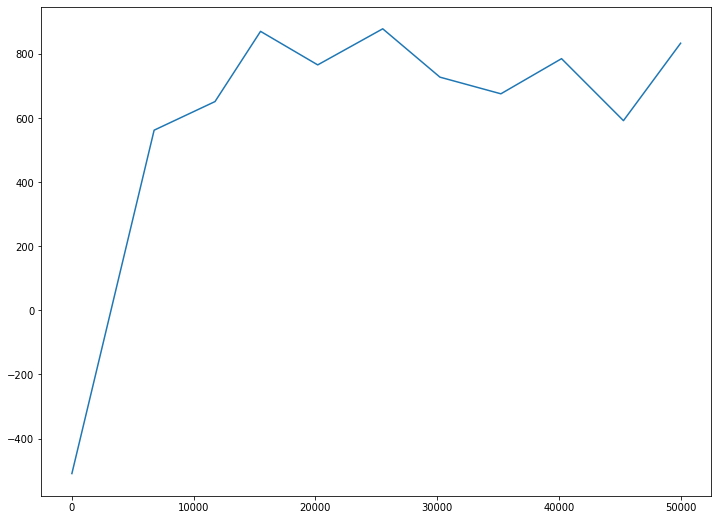

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.lineplot(evaluation_timesteps, evaluations, ax = ax)
plt.savefig('training_eval.png', bbox_inches = 'tight')


Inference

In [ ]:
#Create directories for storing models and evaluations
!pwd
monitor_dir = mkdir('.', 'monitor')
monitor_car_pov_dir = mkdir('.', 'monitor_car_pov')



# Env setup
inference_env_map = CityMap(citymap, roadmask, car_image_resized)
inference_env_map = wrappers.Monitor(inference_env_map, monitor_dir, force = True, video_callable=lambda episode_id: True)
inference_env_map.reset()

inference_env_car = CityMap(citymap, roadmask, car_image_resized, render_pov = 'car')
inference_env_car = wrappers.Monitor(inference_env_car, monitor_car_pov_dir, force = True, video_callable=lambda episode_id: True)
inference_env_car.reset();

What the car sees in the inference_env_car environment at the starting point

In [ ]:
Image.fromarray( inference_env_car.unwrapped._extract_current_frame().squeeze(0).squeeze(0)*255 ).convert('L').resize((80,80))

In [ ]:
# Loading the model
inference_policy = TD3(
    action_dim, 
    max_action, 
    batch_size = batch_size, 
    discount = discount, 
    polyak = polyak, 
    policy_noise = policy_noise, 
    noise_clip = noise_clip, 
    policy_freq = policy_freq, 
    actor_lr = actor_lr,
    critic_lr = critic_lr,
    device = device)
inference_policy.load(file_name, './pytorch_models/')

In [ ]:
#Map POV
avg_reward_map = evaluate_policy(inference_policy, inference_env_map, eval_episodes=3)

# Wrapup recording
inference_env_map.close()
inference_env_map.stats_recorder.save_complete()
inference_env_map.stats_recorder.done = True

# #Car POV
avg_reward_car = evaluate_policy(inference_policy, inference_env_car, eval_episodes=3)

# Wrapup recording
inference_env_car.close()
inference_env_car.stats_recorder.save_complete()
inference_env_car.stats_recorder.done = True